<h1>CNN Token-Level Language Model</h1>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# model classes

class Linear:
		
		def __init__(self, fan_in, fan_out, bias=True):
				self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming initialization
				self.bias = torch.zeros(fan_out) if bias else None
				
		def __call__(self, x):
				self.out = x @ self.weight
				if self.bias is not None:
						self.out += self.bias
				return self.out
		
		def parameters(self):
				return [self.weight] + ([] if self.bias is None else [self.bias])
		
		
class BatchNorm1d:
		
		def __init__(self, dim, eps=1e-5, momentum=0.1):
				self.eps = eps
				self.momentum = momentum
				self.training = True
				# parameters (trained with backprop)
				self.gamma = torch.ones(dim)
				self.beta = torch.zeros(dim)
				# buffers (trained with updates)
				self.running_mean = torch.zeros(dim)
				self.running_var = torch.ones(dim)
				
		def __call__(self, x):
				# calculate forward pass
				if self.training:
					if x.ndim == 2:
						dim = 0
					elif x.ndim == 3:
						dim = (0,1)
					x_mean = x.mean(dim, keepdim=True)
					x_var = x.var(dim, keepdim=True)
				else:
						x_mean = self.running_mean
						x_var = self.running_var
				
				x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
				self.out = self.gamma * x_hat + self.beta
				
				if self.training:
						with torch.no_grad():
								self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
								self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
				
				return self.out
								
		def parameters(self):
				return [self.gamma, self.beta]
  
class Embedding:
	def __init__(self, num_embeddings, embedding_dim):
		self.weight = torch.randn((num_embeddings, embedding_dim))
  
	def __call__(self, IX):
		self.out = self.weight[IX]
		return self.out

	def parameters(self):
		return [self.weight]

class FlattenConsecutive:

	def __init__(self, n):
		self.n = n
	def __call__(self, x):
		B, T, C = x.shape
		x = x.view(B, T//self.n, C*self.n)
		if x.shape[1] == 1:
			x = x.squeeze(1)
		self.out = x
		return self.out
	def parameters(self):
		return []
  						
class Tanh:
		def __call__(self, x):
				self.out = torch.tanh(x)
				return self.out
		def parameters(self):
				return []
  
class Sequential:
	
	def __init__(self, layers):
		self.layers = layers
	
	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		self.out = x
		return self.out

	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

In [3]:
torch.manual_seed(42);

In [4]:
# read words
words = open('../data/names.txt').read().splitlines()
# lookup table
alphabet = sorted(list(set(''.join(words) + '.')))
stoi = {s:i for i,s in enumerate(alphabet)}
itos = {ind: char for char, ind in stoi.items()}

In [5]:
block_size = 8
def build_dataset(words):
	X = []
	Y = []
	for word in words:
		context = [0] * block_size
		for c in word + '.':
			char_ind = stoi[c]
			X.append(context)
			Y.append(char_ind)
			context = context[1:] + [char_ind]
	X, Y = torch.tensor(X), torch.tensor(Y)
	print(X.shape, Y.shape)	
	return X, Y


vocab_size = 27

In [6]:
n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))
train_x, train_y = build_dataset(words[:n1])
val_x, val_y = build_dataset(words[n1:n2])
test_x, test_y = build_dataset(words[n2:])

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [7]:
for x, y in zip(train_x[:10], train_y[:10]):
	print(''.join(itos[char.item()] for char in x), "->", itos[y.item()])

........ -> e
.......e -> m
......em -> m
.....emm -> a
....emma -> .
........ -> o
.......o -> l
......ol -> i
.....oli -> v
....oliv -> i


In [8]:
n_embed = 24
n_hidden = 128


model = Sequential([
  Embedding(vocab_size, n_embed),
	FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias = False), BatchNorm1d(n_hidden),Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden),Tanh(),
 	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden),Tanh(),
	Linear(n_hidden, vocab_size),
])

with torch.no_grad():
		model.layers[-1].weight *= 0.1 # make last layer less confident
		
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
		p.requires_grad = True

76579


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

	# construct batch
	indexes = torch.randint(0, train_x.shape[0], (batch_size,))
	x_batch = train_x[indexes]
	y_batch = train_y[indexes]
 
	# forward pass
	logits = model(x_batch)
	loss = F.cross_entropy(logits, y_batch)
 
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

 
	# update
	lr = 0.1 if i < 100000 else 0.01
	for p in parameters:
		p.data += - p.grad * lr
  
  # track
	lossi.append(loss.item())
 
	if i % 1000 == 0:
		print(f'{i:7d}/{max_steps}: loss = {loss.item():.4f}')

      0/200000: loss = 3.2929
   1000/200000: loss = 2.0377
   2000/200000: loss = 2.2227
   3000/200000: loss = 2.0323
   4000/200000: loss = 2.2397
   5000/200000: loss = 2.6253
   6000/200000: loss = 1.9508
   7000/200000: loss = 2.1844
   8000/200000: loss = 1.7564
   9000/200000: loss = 2.2394
  10000/200000: loss = 2.0977
  11000/200000: loss = 2.2625
  12000/200000: loss = 1.7151
  13000/200000: loss = 2.1367
  14000/200000: loss = 1.5408
  15000/200000: loss = 2.1437
  16000/200000: loss = 2.5795
  17000/200000: loss = 1.7183
  18000/200000: loss = 2.2867
  19000/200000: loss = 1.8430
  20000/200000: loss = 1.8548
  21000/200000: loss = 1.9766
  22000/200000: loss = 1.6991
  23000/200000: loss = 2.1370
  24000/200000: loss = 1.8525
  25000/200000: loss = 1.8962
  26000/200000: loss = 2.2772
  27000/200000: loss = 2.0467
  28000/200000: loss = 1.5977
  29000/200000: loss = 1.9046
  30000/200000: loss = 2.0830
  31000/200000: loss = 1.8442
  32000/200000: loss = 2.0329
  33000/20

In [10]:
for layer in model.layers:
	print(layer.__class__.__name__, ':', layer.out.shape)

Embedding : torch.Size([32, 8, 24])
FlattenConsecutive : torch.Size([32, 4, 48])
Linear : torch.Size([32, 4, 128])
BatchNorm1d : torch.Size([32, 4, 128])
Tanh : torch.Size([32, 4, 128])
FlattenConsecutive : torch.Size([32, 2, 256])
Linear : torch.Size([32, 2, 128])
BatchNorm1d : torch.Size([32, 2, 128])
Tanh : torch.Size([32, 2, 128])
FlattenConsecutive : torch.Size([32, 256])
Linear : torch.Size([32, 128])
BatchNorm1d : torch.Size([32, 128])
Tanh : torch.Size([32, 128])
Linear : torch.Size([32, 27])


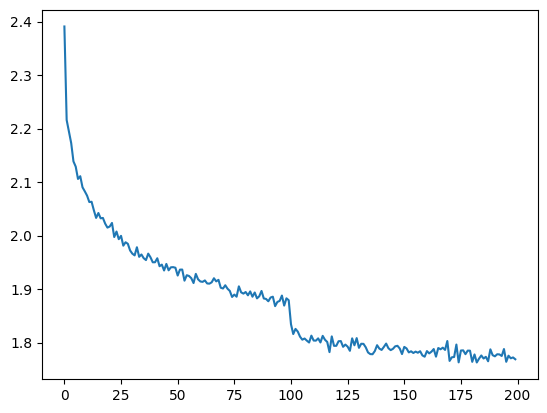

In [11]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [12]:
for layer in model.layers:
	layer.training = False

In [13]:
# eval loss
@torch.no_grad()
def split_loss(split):
	x,y = {
		'train': (train_x, train_y),
		'val': (val_x, val_y),
		'test': (test_x, test_y),
	}[split]
	logits = model(x)
	loss = F.cross_entropy(logits, y)
	print(split, loss.item())
 
split_loss('train')
split_loss('val')

train 1.7393323183059692
val 2.236931324005127


In [14]:
for _ in range(20):
	
	out = []
	context = [0] * block_size
	while True:
		logits = model(torch.tensor([context]))
		probs = F.softmax(logits, dim=1)
		ix = torch.multinomial(probs, num_samples=1).item()
  
		context = context[1:] + [ix]
		out.append(ix)
		if ix == 0:
			break
	print(''.join(itos[i] for i in out))


arlijah.
ella.
heavyn.
jovie.
meelaj.
aidem.
airabro.
clarisa.
maelyn.
blaya.
sarah.
astaniya.
alayva.
aniah.
jayce.
norielle.
mita.
niyeli.
gian.
nita.


### performance log

- original: mlp w/ 8 chars of context (train 1.88, val 2.25) 
- CNN iteration V1: wavenet implementation ()